#### We  would run a set of models to establish a base line of accuracy

In [1]:
import pandas as panda
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,label_binarize

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RepeatedStratifiedKFold,learning_curve

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, \
        classification_report,confusion_matrix,average_precision_score
from sklearn.linear_model import Perceptron, LogisticRegression,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plot
from itertools import cycle
import numpy as np 
from scipy import interp
import seaborn as sns
import itertools, time, datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from numpy import bincount, linspace, mean, std, arange, squeeze

import warnings

warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
np.random.seed(123)

In [3]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plot.imshow(cm, interpolation='nearest', cmap=cmap)
    plot.title(title)
    plot.colorbar()
    tick_marks = arange(len(classes))
    plot.xticks(tick_marks, classes, rotation=45)
    plot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plot.ylabel('True label')
    plot.xlabel('Predicted label')
#     plot.tight_layout()
    plot.show()

In [5]:
## over sampling majorities first 

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
# _x_train, _y_train = smt.fit_sample(_x_train, _y_train)

# smote = SMOTE(ratio='minority')
# x_train, y_train = smote.fit_sample(_x_train,_y_train)

# tl = TomekLinks(return_indices=True, ratio='majority')
# _x_train, _y_train, id_tl = tl.fit_sample(_x_train, _y_train)



In [6]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))





def calculate_roc_and_prec_metrics(y, y_probabilities, number_of_classes):
    
    false_positive_rate_across_class    = dict()
    true_positive_rate_across_class     = dict()
    recall_across_class                 = dict()
    precision_across_class              = dict()
    roc_auc_across_class                = dict()
    average_precision_across_class      = dict()


    for i in range(number_of_classes):

        false_positive_rate_across_class[i], \
                true_positive_rate_across_class[i], _ = roc_curve(y[:, i], y_probabilities[:, i])

        precision_across_class[i], recall_across_class[i], _ = precision_recall_curve(y[:, i],
                                                        y_probabilities[:, i])

        average_precision_across_class[i] = average_precision_score(y[:, i], y_probabilities[:, i])

        roc_auc_across_class[i] = auc(false_positive_rate_across_class[i], true_positive_rate_across_class[i])

        # Compute micro-average ROC curve and ROC area

        false_positive_rate_across_class["micro"], \
                true_positive_rate_across_class["micro"], _ = roc_curve(y.ravel(), y_probabilities.ravel())

        roc_auc_across_class["micro"] = auc(false_positive_rate_across_class["micro"], \
                            true_positive_rate_across_class["micro"])


        precision_across_class["micro"], recall_across_class["micro"], _ = \
                    precision_recall_curve(y.ravel(), y_probabilities.ravel())

        average_precision_across_class["micro"] = average_precision_score(y, y_probabilities,
                                                            average="micro")

    response  = dict() 
    response['false_positive_rate_across_class']    = false_positive_rate_across_class
    response['true_positive_rate_across_class']     = true_positive_rate_across_class
    response['recall_across_class']                 = recall_across_class
    response['precision_across_class']              = precision_across_class
    response['roc_auc_across_class']                = roc_auc_across_class
    response['average_precision_across_class']      = average_precision_across_class

    return response


def plot_roc_auc_curve(false_positive_rate_across_class, \
            true_positive_rate_across_class, roc_auc_across_class, n_classes):
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([false_positive_rate_across_class[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += interp(all_fpr, false_positive_rate_across_class[i], true_positive_rate_across_class[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    false_positive_rate_across_class["macro"] = all_fpr
    true_positive_rate_across_class["macro"] = mean_tpr
    roc_auc_across_class["macro"] = auc(false_positive_rate_across_class["macro"], true_positive_rate_across_class["macro"])

    # Plot all ROC curves
    plot.figure(figsize = (15,5))
    plot.plot(false_positive_rate_across_class["micro"], true_positive_rate_across_class["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc_across_class["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plot.plot(false_positive_rate_across_class["macro"], true_positive_rate_across_class["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc_across_class["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plot.plot(false_positive_rate_across_class[i], true_positive_rate_across_class[i], color=color, lw=4,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc_across_class[i]))

    plot.plot([0, 1], [0, 1], 'k--', lw=4)
    plot.xlim([0.0, 1.0])
    plot.ylim([0.0, 1.05])
    plot.xlabel('False Positive Rate')
    plot.ylabel('True Positive Rate')
    plot.title('Some extension of Receiver operating characteristic to multi-class')
    plot.legend(loc="lower right")
    plot.show()




def plot_precision_recall_curve(recall_across_class, \
            precision_across_class, average_precision_across_class, n_classes):

    line_width = 4
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plot.figure(figsize=(15, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plot.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plot.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plot.plot(recall_across_class["micro"], precision_across_class["micro"], color='gold', lw=line_width)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision_across_class["micro"]))

    for i, color in zip(range(n_classes), colors):
        l, = plot.plot(recall_across_class[i], precision_across_class[i], color=color, lw=line_width)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                    ''.format(i, average_precision_across_class[i]))

    fig = plot.gcf()
    fig.subplots_adjust(bottom=0.25)
    plot.xlim([0.0, 1.0])
    plot.ylim([0.0, 1.05])
    plot.xlabel('Recall')
    plot.ylabel('Precision')
    plot.title('Extension of Precision-Recall curve to multi-class')
#     plot.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))
    plot.legend(lines, labels, loc='best', prop=dict(size=14))
    plot.show()

    

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes")
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()
    
    
def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
    
    response = {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    with training_timer:
        
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)

    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
    print("F1 score %s" %f1_score(y_test,y_prediction, average ='weighted'))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(_x_train, _y_train, search.best_estimator_)
#         _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(range(_y_test.shape[1])))
        _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(set(_y_test)))
        classes = list(set(_y_test))
        plot_confusion_matrix(_matrix, classes)
        
    with predict_proba_timer:

        if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
            print('inside decision function')
            y_probability = gridsearch.predict_proba(_x_test)
            number_of_classes = len(np.unique(y_train))
            y_test_bin = label_binarize(y_test, classes = np.unique(y_train))
            response = calculate_roc_and_prec_metrics(y_test_bin, y_probability, number_of_classes = number_of_classes)

            roc_params = {

                'false_positive_rate_across_class': response.get('false_positive_rate_across_class'),
                'true_positive_rate_across_class': response.get('true_positive_rate_across_class'),
                'roc_auc_across_class': response.get('roc_auc_across_class'),
                'n_classes': number_of_classes
            }

            precision_recall_params  = {

                'precision_across_class': response.get('precision_across_class'),
                'average_precision_across_class': response.get('average_precision_across_class'),
                'recall_across_class': response.get('recall_across_class'),
                'n_classes': number_of_classes
            }

            plot_roc_auc_curve(**roc_params)
            plot_precision_recall_curve(**precision_recall_params)
            response['roc_auc_micro'] = response.get('roc_auc_across_class',{}).get("micro")
            response['roc_auc_macro'] = response.get('roc_auc_across_class',{}).get("macro")
            
            
        else: ## eg SVM, Perceptron doesnt have predict_proba method
            
            response['roc_auc_micro'] = 0
            response['roc_auc_macro'] = 0
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
#     response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction, average ='weighted')
    response['f1_score_micro']  = f1_score(y_test, y_prediction, average ='micro')
    response['f1_score_macro']  = f1_score(y_test, y_prediction, average ='macro')
    response['best_estimator'] = search.best_estimator_
    response['confusion_matrix'] = _matrix
    
    return response


In [7]:
# y = label_binarize(y,classes = np.unique(y))



# _y_train.shape, _y_test.shape

## over sampling majorities first 

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
# _x_train, _y_train = smt.fit_sample(_x_train, _y_train)

In [8]:

## we will add more classifiers in round2
classifiers = [
    XGBClassifier(objective = 'multi:softmax'),
#     LGBMClassifier( objective = 'multiclass')
]


classifier_names = [
            'xgb',
#             'lgb',
]

classifier_param_grid = [
            
            {
#                 'xgb__max_depth':[6,8,10],
                'xgb__max_depth':[8],
#              'xgb__learning_rate':[0.1,0.5,1,2],
             'xgb__learning_rate':[0.1],
#              'xgb__n_estimators':[100,400,1000],
             'xgb__n_estimators':[1000],
#              'xgb__reg_alpha':[0.2,0.3,0.6,1.3],
#              'xgb__reg_lambda':[1.2,1.5],
#              'xgb__booster':['gbtree','dart'],
                'xgb__booster':['gbtree'],
#              'xgb__subsample':[0.5]
            },
    
            {
             'lgb__num_leaves':[25,], \
             'lgb__min_data_in_leaf':[20],\
             'lgb__max_depth':[20,], \
             'lgb__learning_rate' : [0.01,],\
             'lgb__min_child_samples' :[100,], \
             'lgb__n_estimators' : [5000,], \
             'lgb__num_boost_round' : [100], \
             'lgb__feature_fraction' : [0.9,], \
             'lgb__bagging_freq' : [1,], \
             'lgb__bagging_seed' : [123], \
            },
    
]


In [9]:

def execute( _x_train,
             _y_train,
             _x_test,
             _y_test, 
            classifiers, 
            classifier_names, 
            classifier_param_grid,
            cv  = 10 , 
            score = 'accuracy',
            scaler = StandardScaler()
           ):
    
    '''
    This method will run your data sets against the model specified 
    Models will be fed through a pipeline where the first step would be to
    execute a scaling operation.
    
    Method will also call additional lower level methods in order to plot
    precision curve, roc curve, learning curve and will also prepare a confusion matrix
    
    :returns: dict containing execution metrics such as time taken, accuracy scores
    :returntype: dict
    
    '''

    timer = CodeTimer(name='overalltime')
    model_metrics = {}

    with timer:
        for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

            pipeline = Pipeline([
                    ('scaler', scaler),
                    (model_name, model)
            ])

            result = runGridSearchAndPredict(pipeline, 
                                             _x_train,
                                             _y_train,
                                             _x_test,
                                             _y_test, 
                                             model_param_grid ,
                                             cv = cv,
                                             score = 'f1_weighted')

            _y_prediction = result['_y_prediction']

#             cf = panda.crosstab(
#                 panda.Series(_y_test, name='Actual'),
#                 panda.Series(_y_prediction, name = 'Prediction'),
#                 margins = True
#             )

#             print(cf)

            model_metrics[model_name] = {}
            model_metrics[model_name]['confusion_matrix'] = result.get('confusion_matrix')
            model_metrics[model_name]['training_time'] = result.get('training_time')
            model_metrics[model_name]['testing_time'] = result.get('testing_time')
            model_metrics[model_name]['learning_curve_time'] = result.get('learning_curve_time')
            model_metrics[model_name]['f1_score'] = result.get('f1_score')
            model_metrics[model_name]['f1_score_macro'] = result.get('f1_score_macro')
            model_metrics[model_name]['f1_score_micro'] = result.get('f1_score_micro')
            model_metrics[model_name]['roc_auc_macro'] = result.get('roc_auc_macro')
            model_metrics[model_name]['roc_auc_micro'] = result.get('roc_auc_micro')

            model_metrics[model_name]['best_estimator'] = result.get('best_estimator')
#             model_metrics[model_name]['cf'] = cf


    print(timer.took)
    
    return model_metrics


In [10]:
train_data = panda.read_csv('data/train_2.csv')
test_data = panda.read_csv('data/test_2.csv')

In [11]:

columns_not_required = ['id','idhogar','target']
x = train_data[[i for i in train_data.columns.tolist() if i not in columns_not_required]]
y = train_data['target']


In [12]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)


In [13]:
_y_train[_y_train==4].shape[0]

1368

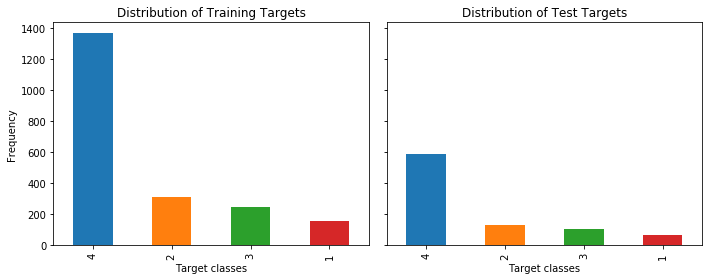

In [14]:


f, (ax1, ax2) = plot.subplots(1, 2, sharey=True, figsize=(10,4))
_y_train.value_counts().plot(kind='bar', label='Distribution of Training targets',ax=ax1)

ax1.set_xlabel('Target classes')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Training Targets')

_y_test.value_counts().plot(kind='bar', label='Distribution of Training targets', ax=ax2)

ax2.set_xlabel('Target classes')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Test Targets')
plot.tight_layout()
plot.show()

In [15]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'f1_weighted'
scaler = StandardScaler()

Grid Search Best parameters  {'xgb__booster': 'gbtree', 'xgb__learning_rate': 0.1, 'xgb__max_depth': 8, 'xgb__n_estimators': 1000}
Grid Search Best score  0.6194171488938507
Code block 'training' took(HH:MM:SS): 0:07:27.532473
Code block 'testing' took(HH:MM:SS): 0:00:00.251495
F1 score 0.6068637506739141
Classification report  
               precision    recall  f1-score   support

           1       0.31      0.18      0.23        67
           2       0.32      0.32      0.32       133
           3       0.10      0.07      0.08       106
           4       0.77      0.86      0.81       586

   micro avg       0.63      0.63      0.63       892
   macro avg       0.37      0.35      0.36       892
weighted avg       0.59      0.63      0.61       892



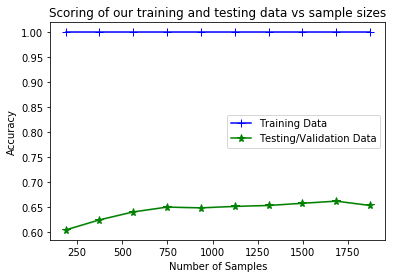

Confusion matrix, without normalization
[[ 12  22   8  25]
 [ 13  42  19  59]
 [  3  29   7  67]
 [ 11  39  33 503]]


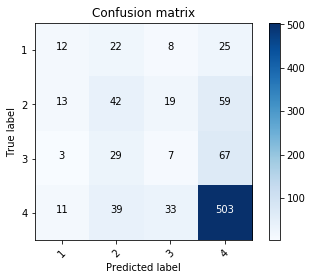

Code block 'learning_curve' took(HH:MM:SS): 1:08:50.327425
inside decision function


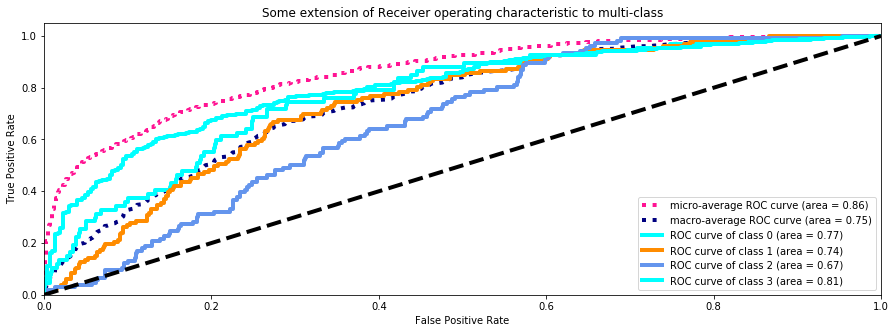

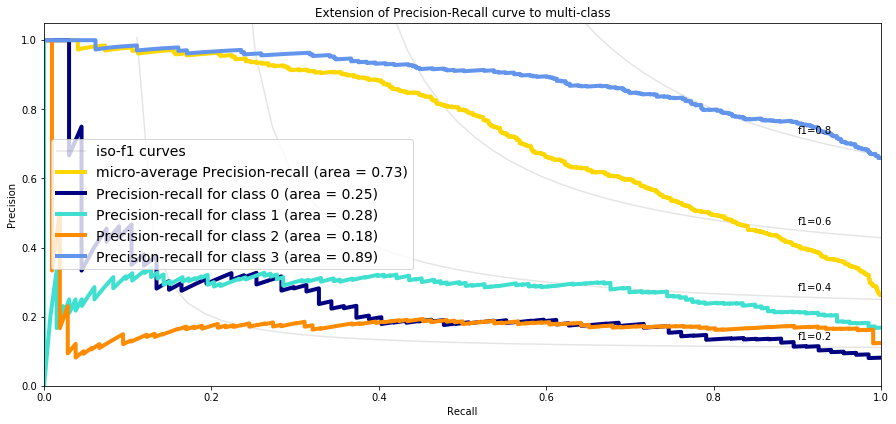

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.672032
Code block 'overalltime' took(HH:MM:SS): 1:16:18.790194
4578790.1944063455


In [16]:
response = execute(_x_train,
        _y_train,
        _x_test,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [19]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
xgb,0.606864,0.358903,0.632287,4.13033e+06,0.748682,0.859816,251.495,447532


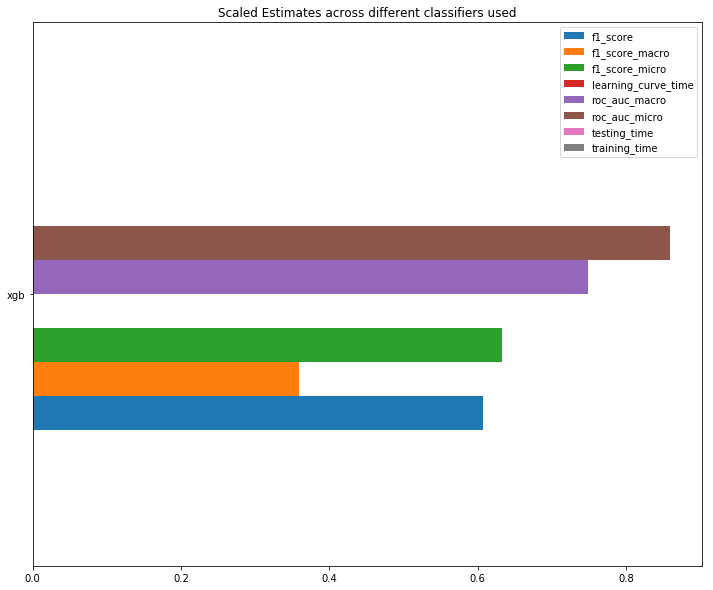

In [20]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

#### Conclusion on our baseline model: Logistic Regression works the best with f1_micro score of 0.66 and roc score of 0.86

